CSC180 Project #2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting up Environment

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import sys
import sklearn as sk
import pandas as pd
import sklearn.feature_extraction.text as sk_text
from collections.abc import Sequence
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import shutil
import os
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten
import io
from sklearn.model_selection import train_test_split

print("Python {}".format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print("Tensor Flow Version: {}".format(tf.__version__))

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Pandas 1.5.3
Numpy 1.23.5
Scikit-Learn 1.2.2

Tensor Flow Version: 2.13.0


Helper Functions

In [ ]:
#helpful functions
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

In [ ]:
#Read the files in
import json
import csv

test_set = pd.read_csv('drive/MyDrive/CSC180 Project 2 Dataset/UNSW_NB15_test-set.csv')
training_set = pd.read_csv('drive/MyDrive/CSC180 Project 2 Dataset/UNSW_NB15_training-set.csv')

In [ ]:
test_set.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
training_set.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


Data Cleaning

In [ ]:
#remove empty values
training_set.dropna(inplace=True)
test_set.dropna(inplace=True)

In [ ]:
#find most categorical features
training_unique = training_set.select_dtypes(include='object').columns

training_unique

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')

In [ ]:
#remove attack-type feature as it adversley affects results
training_set = training_set.drop(columns=['attack_cat'])
test_set = test_set.drop(columns=['attack_cat'])

In [ ]:
#see what unique values are in the training/test sets for the categorical features
unique_training_values = (training_set['proto'].append(training_set['service']).append(training_set['state']).append(training_set['ct_state_ttl'])).unique()
unique_test_values = (test_set['proto'].append(test_set['service']).append(test_set['state']).append(test_set['ct_state_ttl'])).unique()



<ipython-input-8-e7e9ba2dd169>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique_training_values = (training_set['proto'].append(training_set['service']).append(training_set['state']).append(training_set['ct_state_ttl'])).unique()
<ipython-input-8-e7e9ba2dd169>:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique_training_values = (training_set['proto'].append(training_set['service']).append(training_set['state']).append(training_set['ct_state_ttl'])).unique()
<ipython-input-8-e7e9ba2dd169>:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  unique_test_values = (test_set['proto'].append(test_set['service']).append(test_set['state']).append(test_set['ct_state_ttl'])).unique()
<ipython-input-8-e7e9ba2dd169>:3: Futur

In [ ]:
#remove the records whose categorical feature values are in exclusivley the training set or test set
values_to_remove = []
for value in unique_training_values :
  if (value not in unique_test_values) :
    values_to_remove.append(value)

for value in unique_test_values :
  if (value not in unique_training_values) :
    values_to_remove.append(value)

values_to_remove

['icmp', 'rtp', 'ECO', 'PAR', 'URN', 'no', 'ACC', 'CLO', 4, 5]

Removing Unique values

In [ ]:
training_set = training_set[~training_set['proto'].isin(values_to_remove)]
training_set = training_set[~training_set['service'].isin(values_to_remove)]
training_set = training_set[~training_set['state'].isin(values_to_remove)]
#training_set = training_set[~training_set['attack_cat'].isin(values_to_remove)]
training_set = training_set[~training_set['ct_state_ttl'].isin(values_to_remove)]

test_set = test_set[~test_set['proto'].isin(values_to_remove)]
test_set = test_set[~test_set['service'].isin(values_to_remove)]
test_set = test_set[~test_set['state'].isin(values_to_remove)]
#test_set = test_set[~test_set['attack_cat'].isin(values_to_remove)]
test_set = test_set[~test_set['ct_state_ttl'].isin(values_to_remove)]

In [ ]:
#remove non-binary values from the binary columns
training_set = training_set[~training_set['is_ftp_login'].isin(range(2,5))]
test_set = test_set[~test_set['is_ftp_login'].isin(range(2,5))]

In [ ]:
#list of categorical vs non-categorical
categorical_cols = ['proto', 'service', 'state', 'ct_state_ttl']
non_categorical_cols = [col for col in list(training_set.columns) if (col not in (categorical_cols))]
non_categorical_cols.remove('label')
#remove binary cols
non_categorical_cols.remove('is_ftp_login')
non_categorical_cols.remove('is_sm_ips_ports')
non_categorical_cols.remove('id')

In [ ]:
#split data into x train/test and y train/test
x_train = training_set.drop(columns=['label'])
x_test = test_set.drop(columns=['label'])
y_train = pd.DataFrame(training_set['label'])
y_test = pd.DataFrame(test_set['label'])


In [ ]:
print(x_train.shape)
print(x_test.shape)

(175303, 43)
(82296, 43)


In [ ]:
#drop duplicate id col
x_train = x_train.drop(columns='id')
x_test = x_test.drop(columns='id')


In [ ]:
#z-score the non-categorical and non-binary features
from scipy.stats import zscore

x_train[non_categorical_cols] = zscore(x_train[non_categorical_cols])
x_test[non_categorical_cols] = zscore(x_test[non_categorical_cols])

In [ ]:
#one-hot encoding

for col in categorical_cols:
  encode_text_dummy(x_test,col)
  encode_text_dummy(x_train,col)


In [ ]:
from sklearn.metrics import roc_curve,auc
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

  # Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.src.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

model_svm = SVC(kernel='sigmoid')
model_svm.fit(x_train, y_train)
y_pred = model_svm.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

1951/2572 [=====================>........] - ETA: 2s

In [ ]:
print(metrics.classification_report(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
classification = metrics.classification_report(y_test, y_pred)

plt.figure()
plot_confusion_matrix(confusion_matrix, [0, 1])
plt.show()

Convolutional Neural Network

In [ ]:
x_train.shape

(175303, 192)

In [ ]:
x_test.shape

(82296, 192)

In [ ]:
x_train_cnn = x_train.to_numpy()
x_test_cnn = x_test.to_numpy()

In [ ]:
x_train_cnn = x_train_cnn.reshape((175303, 1, 192, 1))
x_test_cnn = x_test_cnn.reshape((82296, 1, 192, 1))
print(x_train_cnn.shape)
print(x_test_cnn.shape)

(175303, 1, 192, 1)
(82296, 1, 192, 1)


In [ ]:
from tensorflow.keras.optimizers import Adam, SGD
model_con = Sequential()

model_con.add(Conv2D(128, kernel_size = (1, 3), strides=(1,1), activation='relu', input_shape=(1,192,1),padding = 'same'))
model_con.add(MaxPooling2D(pool_size=(1,2)))

model_con.add(Conv2D(64, kernel_size = (1, 3), strides=(1,1), activation='relu'))
model_con.add(MaxPooling2D(pool_size=(1,2)))

model_con.add(Flatten())

model_con.add(Dense(32, activation='sigmoid'))
model_con.add(Dropout(0.8))
model_con.add(Dense(1, activation='sigmoid'))

model_con.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3, patience=5, verbose=2, mode='min')

model_checkpoint = ModelCheckpoint(filepath='cnn/best_weights.hdf5', monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto') # save best model

print(x_train_cnn.shape)
print(x_test_cnn.shape)

model_con.fit(x_train_cnn, y_train, callbacks= [monitor, model_checkpoint], batch_size=128, epochs=100, verbose=2, validation_data =(x_test_cnn,y_test))

model_con.load_weights('cnn/best_weights.hdf5')

pred = model_con.predict(x_test_cnn)
pred = np.argmax(pred, axis=1)

y_true= np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(metrics.classification_report(y_true, pred))

(175303, 1, 192, 1)
(82296, 1, 192, 1)
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.34840, saving model to cnn/best_weights.hdf5
1370/1370 - 17s - loss: 0.2167 - accuracy: 0.9016 - val_loss: 0.3484 - val_accuracy: 0.8091 - 17s/epoch - 12ms/step
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss did not improve from 0.34840
1370/1370 - 8s - loss: 0.1636 - accuracy: 0.9128 - val_loss: 0.3705 - val_accuracy: 0.8110 - 8s/epoch - 6ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.34840 to 0.32102, saving model to cnn/best_weights.hdf5
1370/1370 - 7s - loss: 0.1574 - accuracy: 0.9138 - val_loss: 0.3210 - val_accuracy: 0.8123 - 7s/epoch - 5ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.32102 to 0.28562, saving model to cnn/best_weights.hdf5
1370/1370 - 8s - loss: 0.1530 - accuracy: 0.9211 - val_loss: 0.2856 - val_accuracy: 0.8152 - 8s/epoch - 6ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.28562
1370/1370 - 8s - loss: 0.1513 - accuracy: 0.9290 - val_loss: 0.3063 - val_accuracy: 0.8257 - 8s/epoch - 6ms/step
Epoch 6/100

Epoch 6: val_loss did not improve from 0.28562
1370/1370 - 8s - loss: 0.1497 - accuracy: 0.9316 - val_loss: 0.3128 - val_accuracy: 0.8228 - 8s/epoch - 6ms/step
Epoch 7/100

Epoch 7: val_loss did not improve from 0.28562
1

2572/2572 [==============================] - 9s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

           0       0.45      1.00      0.62     36998
           1       0.00      0.00      0.00     45298

    accuracy                           0.45     82296
   macro avg       0.22      0.50      0.31     82296
weighted avg       0.20      0.45      0.28     82296

[[36998     0]
 [45298     0]]


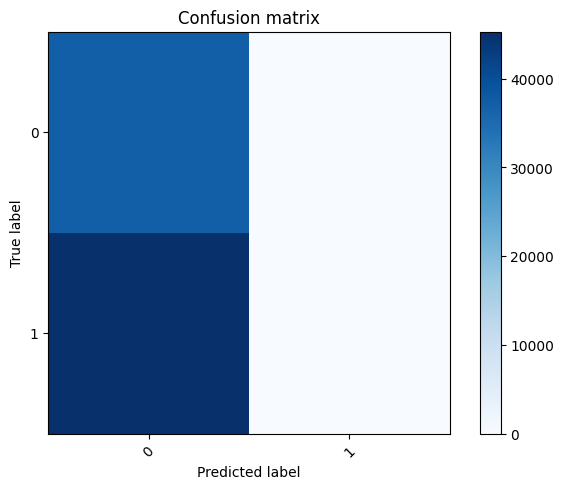

In [ ]:
y_pred = model_con.predict(x_test_cnn)
y_pred = np.argmax(y_pred,axis=1)

print(metrics.classification_report(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
classification = metrics.classification_report(y_test, y_pred)

plt.figure()
plot_confusion_matrix(confusion_matrix, [0, 1])
plt.show()

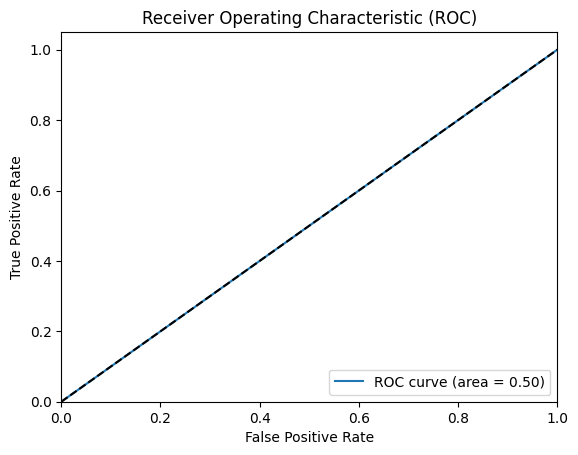

In [ ]:
plot_roc(y_pred, y_test)

Fully Connected Neural Network

In [ ]:
#create and train model
#create and train model
from keras.src.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
save_loc = 'dnn/best_weights.hdf5'

model = Sequential()

model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation = 'relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

monitor = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='auto')

model_checkpoint = ModelCheckpoint(filepath=save_loc, monitor='val_loss',verbose=1,save_best_only=False,save_weights_only=False, mode='auto') # save best model

model.fit(x=x_train, y=y_train,validation_data=(x_test, y_test), callbacks=[monitor, model_checkpoint], verbose=2, epochs=10)

model.load_weights(save_loc)
model.save(save_loc)

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1)

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

Epoch 1/10

Epoch 1: saving model to dnn/best_weights.hdf5
5479/5479 - 22s - loss: 0.2358 - accuracy: 0.9271 - val_loss: 0.3836 - val_accuracy: 0.8135 - 22s/epoch - 4ms/step
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to dnn/best_weights.hdf5
5479/5479 - 21s - loss: 0.1468 - accuracy: 0.9371 - val_loss: 0.3565 - val_accuracy: 0.8135 - 21s/epoch - 4ms/step
Epoch 3/10

Epoch 3: saving model to dnn/best_weights.hdf5
5479/5479 - 21s - loss: 0.1351 - accuracy: 0.9394 - val_loss: 0.3315 - val_accuracy: 0.8216 - 21s/epoch - 4ms/step
Epoch 4/10

Epoch 4: saving model to dnn/best_weights.hdf5
5479/5479 - 21s - loss: 0.1301 - accuracy: 0.9403 - val_loss: 0.3671 - val_accuracy: 0.8140 - 21s/epoch - 4ms/step
Epoch 5/10

Epoch 5: saving model to dnn/best_weights.hdf5
5479/5479 - 22s - loss: 0.1274 - accuracy: 0.9409 - val_loss: 0.3695 - val_accuracy: 0.8169 - 22s/epoch - 4ms/step
Epoch 6/10

Epoch 6: saving model to dnn/best_weights.hdf5
5479/5479 - 22s - loss: 0.1252 - accuracy: 0.9413 - val_loss: 0.4334 - val_accuracy: 0.8177 - 22s/epoch - 4ms/step
Epoch 7/10

Epoch 7: saving model to dnn/best_weights.hdf5
5479/5479 - 20s - loss: 0.1239 - accuracy: 0.9419 - val_loss: 0.3313 - val_accurac

In [ ]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

2572/2572 [==============================] - 19s 8ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.45      1.00      0.62     36998
           1       0.00      0.00      0.00     45298

    accuracy                           0.45     82296
   macro avg       0.22      0.50      0.31     82296
weighted avg       0.20      0.45      0.28     82296

[[36998     0]
 [45298     0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


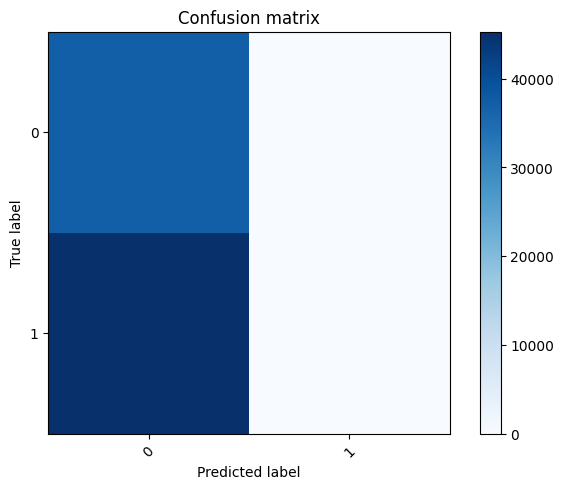

In [ ]:
print(metrics.classification_report(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
classification = metrics.classification_report(y_test, y_pred)

plt.figure()
plot_confusion_matrix(confusion_matrix, [0, 1])
plt.show()

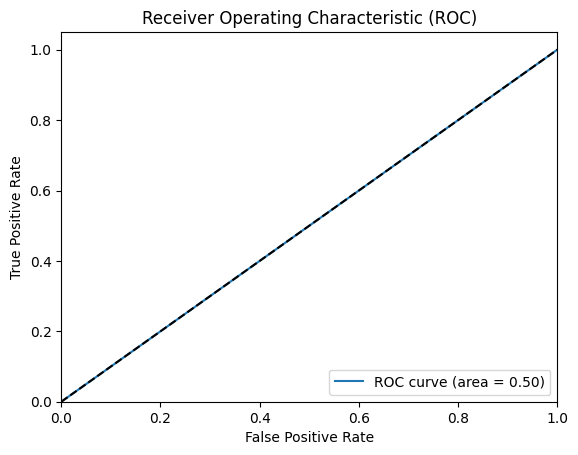

In [ ]:
plot_roc(y_pred, y_test)

Logistic Regression

In [ ]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[24501 12497]
 [ 2544 42754]]


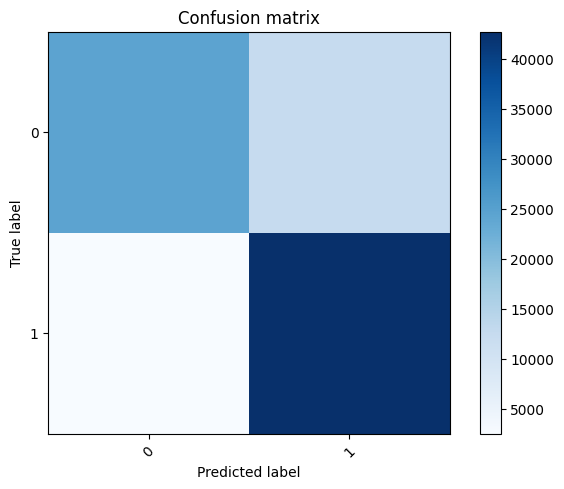

              precision    recall  f1-score   support

           0       0.91      0.66      0.77     36998
           1       0.77      0.94      0.85     45298

    accuracy                           0.82     82296
   macro avg       0.84      0.80      0.81     82296
weighted avg       0.83      0.82      0.81     82296



In [ ]:
from keras.src.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)
classification = metrics.classification_report(y_test, y_pred)

plt.figure()
plot_confusion_matrix(confusion_matrix, [0, 1])
plt.show()

pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

print(metrics.classification_report(y_test, y_pred))


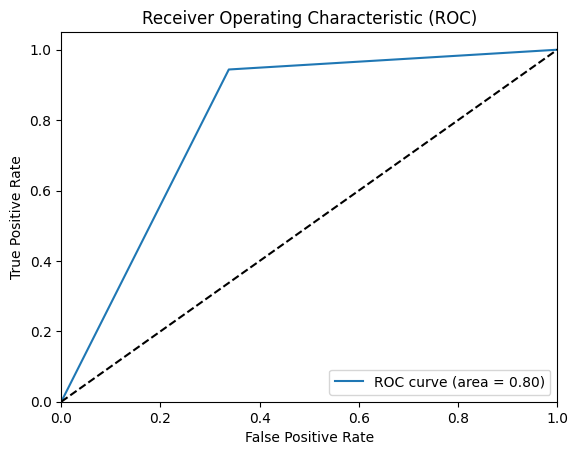

In [ ]:
plot_roc(y_pred, y_test)